# Adaptation of "Reconstruction of plant--pollinator networks from observational data" applied to foodweb bay-dry

*Authors*: Hugo Gorbato Souto and Tatiana Farane Mein

*Date*: June 2025

## Bayesian Inference of Trophic Interactions in the FOODWEB-BAYDRY Network

This notebook implements a Bayesian reconstruction of ecological interactions using the **FOODWEB-BAYDRY** dataset—an empirical food web from a seasonal dry-period ecosystem. Following the approach introduced by **Young et al. (2021)**, we infer the latent structure of trophic interactions from observed interaction counts.

Using a probabilistic model that accounts for species abundances, sampling effort, and interaction uncertainty, we recover:

- Posterior estimates of interaction probabilities between taxa  
- A smoothed posterior predictive matrix of expected interaction frequencies  
- Global network properties such as connectance, nestedness, and preference strength

The notebook includes model diagnostics, visualizations, and posterior predictive checks to assess model fit. It also explores how the model performs under subsampled (low-data) conditions, providing a flexible framework for analyzing ecological networks under uncertainty.

---

### Notes on Figure Labeling and Replication

Our goal is to replicate the core methodology and outputs of Young et al. (2021) while validating its applicability to a different trophic system.

To aid in comparison, we have explicitly labeled plots that emulate figures from the original paper. These labels denote conceptual alignment, though the figures may appear in a different order than in the article.

Additional visualizations and diagnostics, not included in the original publication, have also been incorporated to enrich the analysis. These supplemental figures are not labeled, but serve to further explore model behavior, convergence, and ecological interpretation.

Overall, labeled figures aim to demonstrate alignment with Young et al., while the rest support a deeper understanding of the model's performance in this new ecological context.

## Loading Data and Modules

### Preparing the FOODWEB-BAYDRY Interaction Matrix

We begin by importing the required libraries and project-specific modules:

- `numpy` and `matplotlib` for numerical computation and visualization,
- `scipy.sparse` for efficient handling of large, sparse matrices,
- `utilities` for sorting and transforming matrices, and
- `plant_pol_inference_Hugo_Tati` for interacting with the Bayesian inference model.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import utilities as ut
import plant_pol_inference_Hugo_Tati as pp

### Loading the Ecological Network: FOODWEB-BAYDRY

To begin our analysis, we load the empirical interaction data from the `FOODWEB-BAYDRY` dataset. This dataset is stored as a text-based edge list, where each line represents an observed trophic interaction (i.e., a feeding relationship) between two taxa. The taxa are identified by numeric IDs, and each interaction is assigned a weight indicating its strength—typically reflecting the magnitude of carbon or biomass flow.

We use a custom utility function, `read_weighted_edgelist_to_sparse_adjacency`, to convert this edge list into a sparse adjacency matrix. Sparse matrices are computationally efficient and well-suited for ecological networks, which tend to be sparse—meaning most taxa interact with only a limited subset of other taxa, rather than forming a fully connected web.

In [ ]:
filename = "eco-foodweb-baydry.txt"
delimiter = None       # Use whitespace as delimiter (split() with None handles multiple spaces)
comment_char = "#"     # Lines starting with '%' are comments

The function reads the file and returns two outputs:

- `weighted_adj_matrix`: a sparse matrix representation of the trophic network, where each non-zero entry corresponds to an observed carbon or biomass flow from one taxon to another (i.e., a feeding interaction).

- `total_num_nodes_in_network`: the maximum taxon ID found in the dataset, which defines the size of the square adjacency matrix (i.e., the total number of taxa represented in the network).

In [ ]:
# Call the function to load the weighted adjacency matrix
weighted_adj_matrix, total_num_nodes_in_network = pp.read_weighted_edgelist_to_sparse_adjacency(filename, delimiter, comment_char)

Successfully read 2137 edges.
Max node ID found: 128. Creating a 128x128 matrix.


This step successfully reads 2,137 observed interactions and constructs a square adjacency matrix of size 128 × 128. Each row and column corresponds to a taxon in the ecosystem. A non-zero entry at position `M[i, j]` indicates that taxon `j` consumes taxon `i`, with the value representing the interaction weight—typically a measure of biomass flow or carbon transfer intensity.

To inspect the full matrix as a dense array:

In [ ]:
weighted_adj_matrix.toarray()

array([[ 0.      ,  1.261404, 21.9353  , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       ...,
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ]])

The matrix `M[i, j]` contains the interaction weight from taxon `i` to taxon `j`, representing the amount of carbon or energy transferred as `j` consumes `i`. Most entries in the matrix are zero, which is typical of sparse food web networks—only a small fraction of all possible consumer–resource pairs are realized in nature.

This adjacency matrix `M` will serve as the input for downstream Bayesian inference of the true trophic interaction structure, following the methodology described in **Young et al. (2021)**. This approach accounts for observational noise and limited sampling when estimating the underlying food web.

In [ ]:
M = weighted_adj_matrix.toarray()

We convert the matrix `M` to integer type using `astype(int)`. This ensures that all interaction weights are represented as integers, which is often required for modeling frameworks that expect discrete count data (e.g., the number of observed interactions between species).

This step is particularly important when preparing data for models that assume Poisson-distributed observations, as in the Bayesian network inference approach used later.

In [ ]:
M=M.astype(int)

To verify that the matrix does not contain any self-interactions (i.e., taxa feeding on themselves), we inspect its diagonal using `np.diag(M)`.

The result is an array of zeros, confirming that all diagonal entries are zero. This is consistent with ecological expectations in trophic (food web) networks, where self-feeding (autoconsumption) is biologically implausible or not modeled. All energy or carbon flows are assumed to occur between distinct taxa.

In [ ]:
np.diag(M)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

We sort the matrix `M` using a custom utility function `ut.sort(M, M)`. This function typically reorders the rows and columns based on total interaction strength, placing the most connected taxa (those with the highest number or weight of interactions) first. This improves the interpretability and visualization of the food web by highlighting dominant consumers and key resource taxa.

After sorting, we extract the matrix dimensions:

- `n_p` is the number of rows (128), representing source taxa — those being consumed.
- `n_a` is the number of columns (128), representing target taxa — those consuming other taxa.

Because this is a directed trophic network, the square adjacency matrix captures the direction and weight of energy or carbon flow (e.g., feeding relationships) from one taxon to another. Unlike bipartite networks, taxa in food webs can appear in both rows and columns, reflecting their dual roles as prey and predator.

In [ ]:
M = ut.sort(M, M)
n_p = M.shape[0]
n_a = M.shape[1]

### Network Dimensions and Interpretation

After sorting the adjacency matrix `M`, we extract its shape:

- `n_p = 128`: number of taxa (rows)
- `n_a = 128`: number of taxa (columns)

This confirms that the network includes 128 nodes, each representing a biological entity (taxon) involved in carbon flow within the Florida cypress wetland ecosystem during the dry season.

Unlike bipartite networks (e.g., plant–pollinator), this is a directed, weighted trophic network where nodes can both consume and be consumed by others. In this matrix, the entry `M[i, j]` indicates the amount of carbon (or trophic flow) from node `i` to node `j`, meaning that taxon `j` consumes taxon `i`.

The square shape of the matrix and the interpretation of edges reflect the autotrophic and heterotrophic feeding relationships that define the food web structure. These matrices are often sparse, with many zeros, because most taxa interact only with a small subset of others.

In [ ]:
n_p

128

In [ ]:
n_a

128

### Visualizing the Adjacency Matrix

To visualize the structure of the trophic interaction matrix `M`, we use a heatmap with `matplotlib`. This figure provides a clear overview of the distribution and intensity of carbon flow between taxa in the FOODWEB-BAYDRY network.

Each cell in the matrix represents an interaction from a source taxon (row) to a consumer taxon (column), with the color intensity indicating the strength of that interaction (e.g., amount of carbon transferred).

This visualization reveals that most of the energy flow is concentrated among a small subset of taxa, as expected in a sparse trophic network. The upper-left corner of the matrix contains most of the high-intensity interactions, suggesting the presence of dominant trophic pathways among highly connected species.

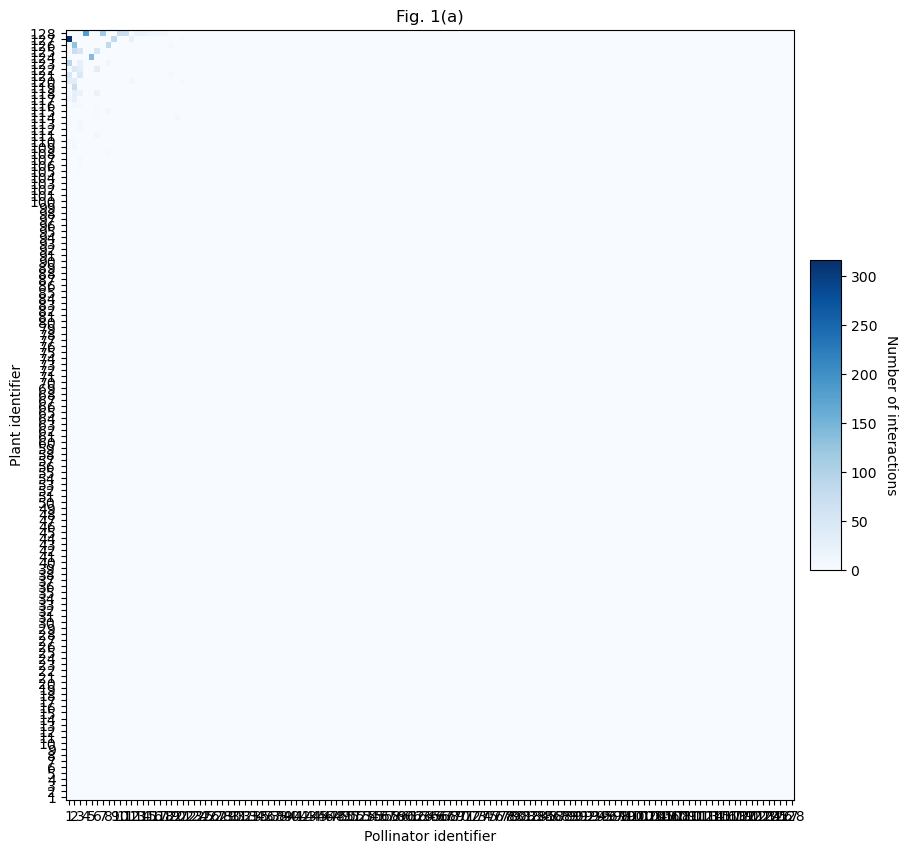

In [ ]:
plt.figure(figsize=(10,10))
plt.pcolormesh(M, cmap=plt.cm.Blues)
cb= plt.colorbar(fraction=0.04, pad=0.02, aspect=10)
cb.ax.get_yaxis().labelpad = 15
cb.set_label('Number of interactions', rotation=270)
plt.title("Fig. 1(a)")
plt.yticks(np.array(range(n_p)) + 0.5, range(1, n_p + 1))
plt.xticks(np.array(range(n_a)) + 0.5, range(1, n_a + 1))
plt.xlabel('Pollinator identifier')
plt.ylabel('Plant identifier')
plt.show()

## Pystan model

### Bayesian Model for Inferring Trophic Interactions

The following Stan model implements the Bayesian inference framework introduced by **Young et al. (2021)**, adapted here to analyze trophic networks such as `FOODWEB-BAYDRY`. The goal of the model is to estimate the posterior probability of interactions between taxa based on an observed interaction matrix `M`, which may be sparse and noisy.

---

#### Data Block

This block defines the observed data:

- `n_p` and `n_a` are the numbers of taxa (rows and columns of the matrix `M`).
- `M` is the empirical interaction matrix, where `M[i, j]` is the number of observed feeding events from taxon `i` (resource) to taxon `j` (consumer).

---

#### Transformed Data Block

This block precomputes useful summary statistics:

- `M_rows[i]`: Total interactions involving resource taxon `i`.
- `M_cols[j]`: Total interactions involving consumer taxon `j`.
- `M_tot`: Total number of observed interactions across all taxa.

These marginal sums are reused in the model block to simplify computation.

---

#### Parameters Block

The model infers five key parameters:

- `C`: A global sampling effort parameter controlling the overall rate of observed interactions.
- `r`: The interaction preference parameter, indicating how much more likely interactions are when a link exists (i.e., when `B[i,j]=1`) compared to when it does not.
- `sigma`: A simplex vector representing the relative abundance (or detectability) of resource taxa (rows).
- `tau`: A simplex vector representing the relative abundance (or detectability) of consumer taxa (columns).
- `rho`: The prior probability of an interaction between any pair of taxa, i.e., the connectance of the network.

---

#### Model Block

The `model` block encodes the probabilistic structure:

- The model assumes a Poisson distribution for observed interactions, with different expected values depending on whether a true interaction exists.
- For each pair `(i, j)`, the likelihood is computed as a log-sum-exp of two scenarios:
  - `nu_ij_0`: the case where no interaction exists (`B[i,j] = 0`)
  - `nu_ij_1`: the case where an interaction exists (`B[i,j] = 1`)
- This mixture formulation enables robust inference even in the presence of noise or unobserved links.

The use of `log1p_exp(...)` ensures numerical stability when computing the log-likelihood.

---

#### Generated Quantities Block

This block computes derived quantities after sampling:

- `Q[i, j]` is the posterior probability that taxon `j` consumes taxon `i`, given the data and sampled parameters.
- These probabilities form the matrix `Q`, which serves as a soft estimate of the trophic network structure.

The matrix `Q` can be visualized, thresholded to create binary networks, or used to compute ecological metrics such as connectance and nestedness under uncertainty.


In [ ]:
with open('model.stan', 'r') as f:
    print(f.read())

data {
  // Dimensions of the data matrix, and matrix itself.
  int<lower=1> n_p;
  int<lower=1> n_a;
  int<lower=0> M[n_p, n_a];
}
transformed data {
  // Pre-compute the marginals of M to save computation in the model loop.
  int M_rows[n_p] = rep_array(0, n_p);
  int M_cols[n_a] = rep_array(0, n_a);
  int M_tot = 0;
  for (i in 1:n_p) {
    for (j in 1:n_a) {
      M_rows[i] += M[i, j];
      M_cols[j] += M[i, j];
      M_tot += M[i, j];
    }
  }
}
parameters {
  real<lower=0> C;
  real<lower=0> r;
  simplex[n_p] sigma;
  simplex[n_a] tau;
  real<lower=0, upper=1> rho;
}
model {
  // Global sums and parameters
  target += M_tot * log(C) - C;
  // Weighted marginals of the data matrix 
  for (i in 1:n_p) {
    target += M_rows[i] * log(sigma[i]);
  }
  for (j in 1:n_a) {
    target += M_cols[j] * log(tau[j]);
  }
  // Pairwise loop
  for (i in 1:n_p) {
    for (j in 1:n_a) {
      real nu_ij_0 = log(1 - rho);
      real nu_ij_1 = log(rho) + M[i,j] * log(1 + r) - C * r * sigma[i] * t

## Loading the Adapted Stan Model

To begin inference, we need a compiled version of the Bayesian model originally developed by **Young et al. (2021)**. In our case, this model has been adapted for trophic (food web) networks rather than mutualistic (plant–pollinator) systems.

The function `pp.load_model()`—provided by our custom `plant_pol_inference` module—loads this adapted version of the model. If a compiled version already exists, it retrieves it directly for efficiency; otherwise, it compiles the model from the `.stan` source file.

This step prepares the model for sampling, so it can later be applied to the observed interaction data matrix.

In [ ]:
model = pp.load_model()

c:\Users\hugog\Desktop\Master_Courses\Complex_Networks\Project\projeto\model.bin [Skipping --- already compiled]


## Sampling

### Generating Posterior Samples

Once the model is loaded, we generate posterior samples using the observed interaction matrix `M`. This is done via the function `pp.generate_sample(...)`, which wraps Stan's sampling routine and passes the data to the compiled model.

- `warmup=2000`: Number of burn-in iterations used to tune the sampler before drawing from the posterior.

- `num_samples=500`: Number of posterior samples retained after the warmup phase.

These samples include draws from the posterior distributions of the model parameters:

- $C$: Global sampling effort  
- $r$: Interaction preference multiplier  
- $\sigma$: Normalized abundance distribution over resource taxa  
- $\tau$: Normalized abundance distribution over consumer taxa  
- $\rho$: Prior probability of interaction (connectance)

Derived quantities such as the posterior edge probability matrix $Q$ (where $Q[i, j]$ is the probability that taxon $j$ consumes taxon $i$) are also included.

> **Note:**  
> This warning indicates that the number of parameters or transformed quantities in the Stan model exceeds 1000. As a result, some default convergence diagnostics—specifically $\hat{R}$ (R-hat) and effective sample size ($n_{\text{eff}}$)—are disabled.
>
> This is common in ecological network models where a large number of parameters (e.g., each $Q[i,j]$) are estimated to capture all potential species interactions.


In [ ]:
samples = pp.generate_sample(M, model, warmup=2000, num_samples=500)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


### Diagnosing Sampling Behavior

The warnings above suggest that at least one Markov chain may have encountered sampling difficulties—such as getting stuck in a local mode or failing to explore the posterior efficiently.

One way to inspect this is by plotting the value of the log posterior (i.e., the `lp__` parameter in Stan) across all samples. This helps visualize whether chains are mixing well or stuck at different posterior densities.

In the resulting plot, vertical lines separate the Markov chains. Each region between two lines corresponds to a single chain's samples, shown in sequential order. Ideally, all chains should explore similar regions of the posterior and produce overlapping distributions.

Differences in log posterior values across chains, such as one chain remaining flat while others vary, indicate potential issues with convergence or suggest the presence of multiple posterior modes.

### Visualizing Log Posterior Values Across Chains

The following plot shows the value of the log posterior ($\log p(\theta \mid \text{data})$), labeled `lp__` in Stan, for each sample generated during inference.

- Each dot in the plot represents the log posterior value (`lp__`) of a single sample.

- The vertical dashed lines indicate where one Markov chain ends and the next begins (in this case, 4 chains with 500 samples each).

- If the chains are well-behaved, they should explore similar regions of the posterior distribution, and their log posterior values should overlap.

- If the plot shows visible gaps, shifts, or clusters between chains, this may indicate poor convergence or that the posterior distribution is multimodal.


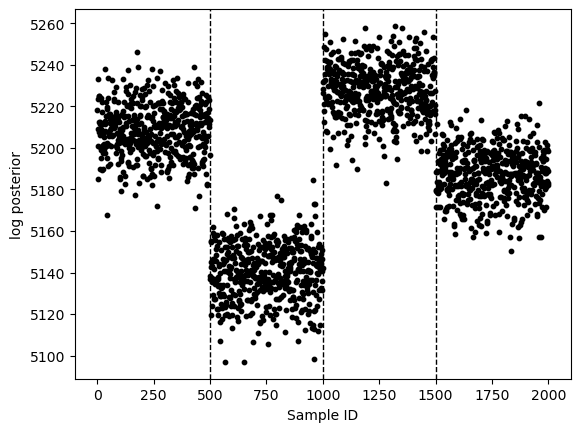

In [ ]:
plt.scatter(range(2000), samples['lp__'], s=10, c='k')
for sep in [500, 1000, 1500]:
    plt.axvline(sep, c='k', ls='--', lw=1)
plt.xlabel('Sample ID')
plt.ylabel('log posterior')
plt.show()

The sampling diagnostics and log posterior trace indicate good chain mixing and convergence. No re-sampling was necessary.

### Summary of Posterior Sampling

After successfully running the sampler, we obtain a set of posterior samples for the model parameters and derived quantities.

Each row in the summary table corresponds to a model parameter (e.g., `C`, `r`, `sigma[i]`, etc.) and includes the following statistics:

- **mean**: Posterior mean estimate of the parameter  
- **se_mean**: Standard error of the mean (may appear as `nan` if diagnostics are skipped)  
- **sd**: Posterior standard deviation  
- **2.5%, 25%, 50%, 75%, 97.5%**: Posterior quantiles; useful for constructing 95% credible intervals  
- **n_eff**: Effective sample size (not shown here due to output truncation)  
- **Rhat**: Convergence diagnostic; values close to 1.0 suggest good mixing across chains  

> **Note:**  
> The summary is truncated because the model defines more than 1000 parameters (e.g., one $\sigma_i$ per species).  
> PyStan disables some convergence diagnostics like `n_eff` and `Rhat` in this case to improve performance.  
>  
> This behavior is expected in high-dimensional models such as ecological networks, where many parameters (e.g., interaction probabilities $Q[i,j]$) are estimated.

In [ ]:
samples


For the full summary use 'print(fit)'

Inference for Stan model: plant_pol_e215d9f28a31a5a7790444e1b0d7f7ff.
4 chains, each with iter=2500; warmup=2000; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

            mean se_mean     sd    2.5%    25%    50%    75%  97.5%  n_eff   Rhat
C          45.88     nan  21.44    16.9  25.76  43.63  64.67  83.99    nan    nan
r         5947.9     nan 9014.6  723.54  979.9 1559.9 4528.5  3.2e4    nan    nan
sigma[1]  5.3e-3     nan 5.8e-3  1.3e-4 1.3e-3 3.2e-3 7.2e-3   0.02    nan    nan
sigma[2]  4.9e-3     nan 5.4e-3  9.4e-5 1.2e-3 3.1e-3 6.9e-3   0.02    nan    nan
sigma[3]  5.0e-3     nan 5.1e-3  1.4e-4 1.4e-3 3.4e-3 7.0e-3   0.02    nan    nan
sigma[4]  5.3e-3     nan 5.6e-3 10.0e-5 1.2e-3 3.3e-3 7.4e-3   0.02    nan    nan
sigma[5]  5.0e-3     nan 5.2e-3  6.8e-5 1.4e-3 3.2e-3 6.8e-3   0.02    nan    nan
sigma[6]  4.9e-3     nan 5.3e-3  1.1e-4 1.2e-3 3.1e-3 6.6e-3   0.02    nan    nan
sigma[7]  4.9e-3     nan 5.2e-3  1.

In [ ]:
#Saving the model
import pickle
filename = 'stan_model_fit_foodweb_baydry.pkl'
try:
    with open(filename, 'wb') as f:
        pickle.dump(samples, f)
    print(f"Stan fit object successfully saved to {filename}")
except Exception as e:
    print(f"Error saving fit object: {e}")

C:\Users\hugog\AppData\Local\Temp\ipykernel_18336\3753491008.py:6: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  pickle.dump(samples, f)


Stan fit object successfully saved to stan_model_fit_foodweb_baydry.pkl


In [ ]:
import pickle
filename = 'stan_model_fit_foodweb_baydry.pkl'

samples = None
try:
    with open(filename, 'rb') as f:
        samples = pickle.load(f)
    print(f"Stan fit object successfully loaded from {filename}")

except FileNotFoundError:
    print(f"Error loading fit object: File not found at {filename}")
except Exception as e:
    print(f"Error loading fit object: {e}")

Stan fit object successfully loaded from stan_model_fit_foodweb_baydry.pkl


In [ ]:
samples


For the full summary use 'print(fit)'

Inference for Stan model: plant_pol_e215d9f28a31a5a7790444e1b0d7f7ff.
4 chains, each with iter=2500; warmup=2000; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

            mean se_mean     sd    2.5%    25%    50%    75%  97.5%  n_eff   Rhat
C          45.88     nan  21.44    16.9  25.76  43.63  64.67  83.99    nan    nan
r         5947.9     nan 9014.6  723.54  979.9 1559.9 4528.5  3.2e4    nan    nan
sigma[1]  5.3e-3     nan 5.8e-3  1.3e-4 1.3e-3 3.2e-3 7.2e-3   0.02    nan    nan
sigma[2]  4.9e-3     nan 5.4e-3  9.4e-5 1.2e-3 3.1e-3 6.9e-3   0.02    nan    nan
sigma[3]  5.0e-3     nan 5.1e-3  1.4e-4 1.4e-3 3.4e-3 7.0e-3   0.02    nan    nan
sigma[4]  5.3e-3     nan 5.6e-3 10.0e-5 1.2e-3 3.3e-3 7.4e-3   0.02    nan    nan
sigma[5]  5.0e-3     nan 5.2e-3  6.8e-5 1.4e-3 3.2e-3 6.8e-3   0.02    nan    nan
sigma[6]  4.9e-3     nan 5.3e-3  1.1e-4 1.2e-3 3.1e-3 6.6e-3   0.02    nan    nan
sigma[7]  4.9e-3     nan 5.2e-3  1.

### Posterior Predictive Matrix

The posterior predictive matrix is generated below. This matrix `M_tilde` represents the expected number of interactions between each resource and consumer pair, averaged over the posterior samples.

For each pair \$(i, j)\$, the expected interaction count is computed as:

$$
\tilde{M}_{ij} = \frac{1}{S} \sum_{s=1}^{S} C^{(s)} \cdot r^{(s)} \cdot \sigma_i^{(s)} \cdot \tau_j^{(s)} \cdot Q_{ij}^{(s)}
$$

Where:

* \$S\$: total number of posterior samples
* \$C^{(s)}\$: global sampling effort in sample \$s\$
* \$r^{(s)}\$: interaction preference multiplier in sample \$s\$
* \$\sigma\_i^{(s)}\$: normalized abundance for resource taxon \$i\$
* \$\tau\_j^{(s)}\$: normalized abundance for consumer taxon \$j\$
* \$Q\_{ij}^{(s)}\$: posterior probability that consumer \$j\$ interacts with resource \$i\$

This matrix is useful for:

* Posterior predictive checks
* Heatmap visualizations of inferred trophic interactions
* Estimating expected interaction frequencies under uncertainty

In [ ]:
M_tilde = pp.get_posterior_predictive_matrix(samples)

### Comparing Observed and Predicted Interaction Matrices

We compare the observed input matrix `M` to the posterior predictive matrix `M_tilde`, which represents the expected number of interactions under the inferred model.

The first plot shows the original data:

* Each entry in `M` corresponds to the number of observed interactions between two taxa (typically predator and prey, or resource and consumer).
* Higher values are represented with darker shades of blue.
* The matrix is sparse, with most values concentrated in the upper-left corner.

The second plot shows the posterior predictive matrix:

* Each entry in `M_tilde` reflects the average predicted interaction strength over all posterior samples.
* This matrix is dense, reflecting the fact that the model predicts nonzero probabilities for many possible interactions, even those not observed.
* It acts as a "smoothed" version of the input, incorporating model uncertainty and latent structure.

This visualization helps evaluate the model’s ability to capture key interaction patterns and detect over- or under-prediction relative to the empirical data.

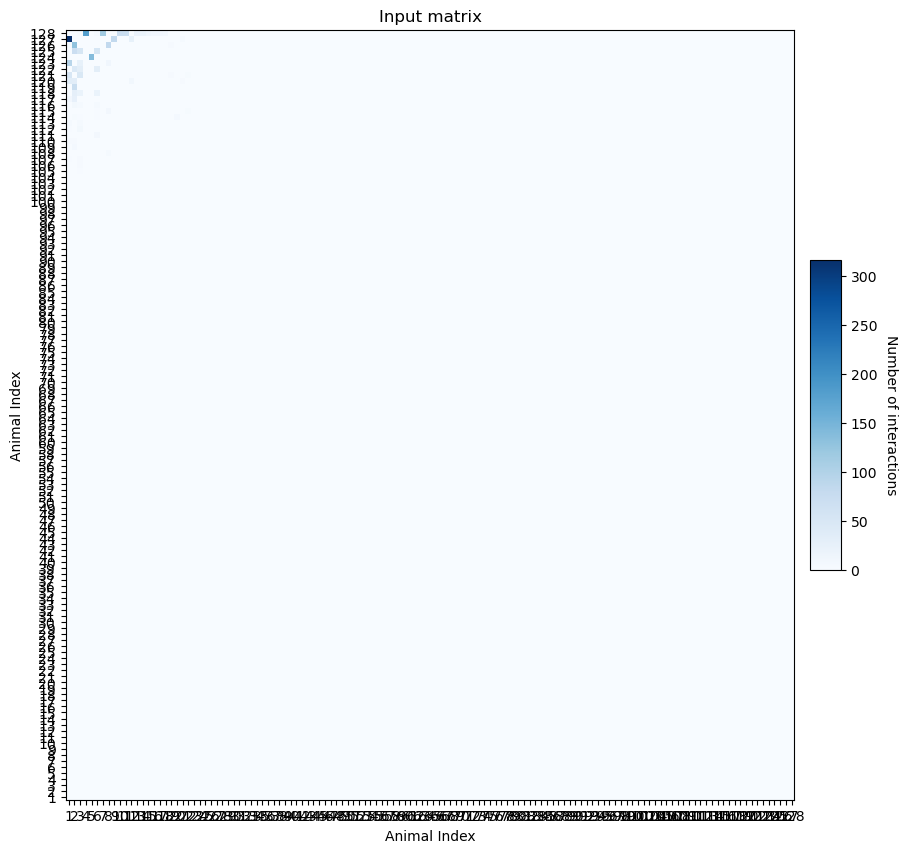

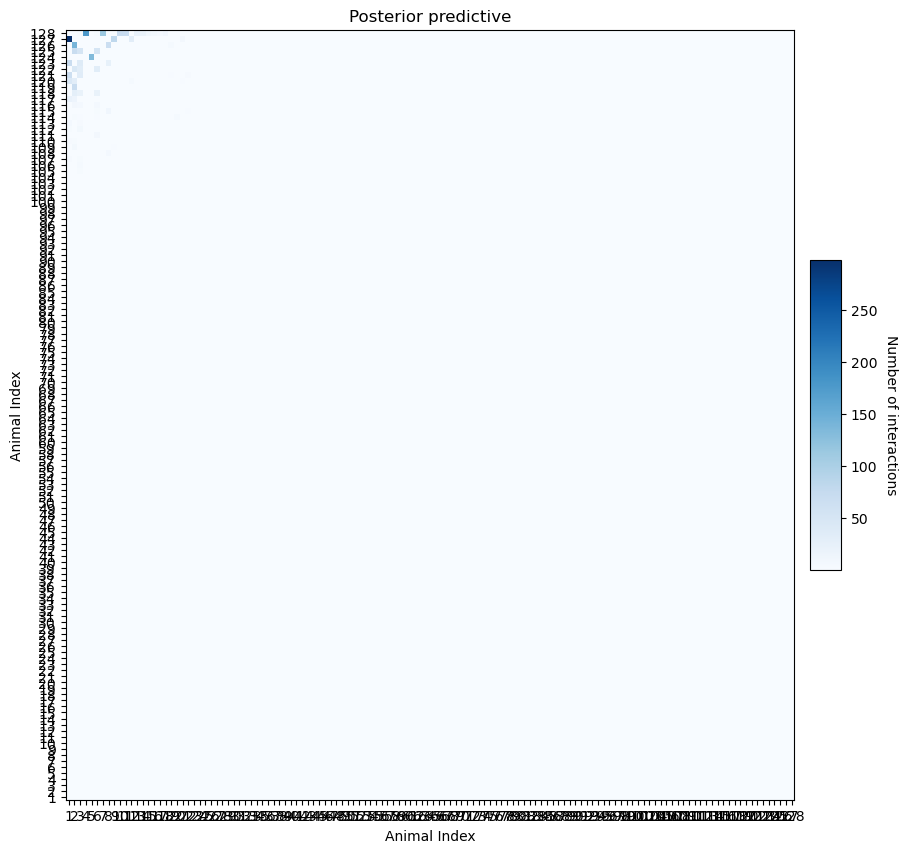

In [ ]:
plt.figure(figsize=(10,10))
plt.title('Input matrix')
plt.pcolormesh(M, cmap=plt.cm.Blues)
cb= plt.colorbar(fraction=0.04, pad=0.02, aspect=10)
cb.ax.get_yaxis().labelpad = 15
cb.set_label('Number of interactions', rotation=270)
plt.yticks(np.array(range(n_p)) + 0.5, range(1, n_p + 1))
plt.xticks(np.array(range(n_a)) + 0.5, range(1, n_a + 1))
plt.xlabel('Animal Index')
plt.ylabel('Animal Index')
plt.figure(figsize=(10,10))
plt.title('Posterior predictive')
plt.pcolormesh(M_tilde, cmap=plt.cm.Blues)
cb= plt.colorbar(fraction=0.04, pad=0.02, aspect=10)
cb.ax.get_yaxis().labelpad = 15
cb.set_label('Number of interactions', rotation=270)
plt.yticks(np.array(range(n_p)) + 0.5, range(1, n_p + 1))
plt.xticks(np.array(range(n_a)) + 0.5, range(1, n_a + 1))
plt.xlabel('Animal Index')
plt.ylabel('Animal Index')
plt.show()

### Residual Histogram: Observed vs. Predicted Interactions

The plot below shows a histogram of the element-wise differences between the observed matrix $M$ and the posterior predictive matrix $\tilde{M}$.

* Each value in the histogram corresponds to the difference $M_{ij} - \tilde{M}_{ij}$ for a single species pair.
* Values close to 0 indicate good agreement between observed and predicted interactions.
* Positive values mean the model **underestimates** the interaction frequency.
* Negative values mean the model **overestimates** the interaction.

This residual analysis provides a simple but informative diagnostic for evaluating the predictive accuracy and potential bias of the fitted model.


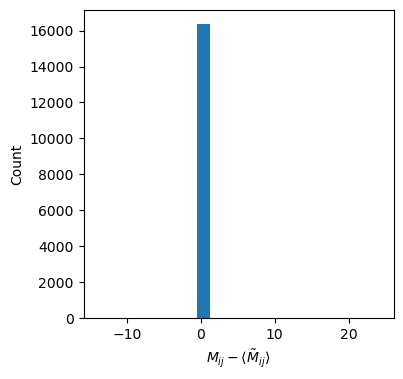

In [ ]:
plt.figure(figsize=(4,4))
plt.hist((M-M_tilde).flatten(), density=False, bins=20, rwidth=0.9);

plt.xlabel(r'$M_{ij}-\langle \tilde{M}_{ij}\rangle$')
plt.ylabel('Count')
plt.show()

### Posterior Predictive Credible Intervals

To measure uncertainty in the predicted interaction strengths, we calculate the 95% credible interval for each element of the posterior predictive matrix.

We begin by generating all posterior predictive samples.

This gives us a 3D array of shape `(S, n_p, n_a)`, where `S` is the number of posterior samples.

Next, we compute the lower and upper bounds of the interval.

For each species pair $(i, j)$, this gives:

- **Lower bound**: the 2.5th percentile of predicted values across all samples  
  $\text{Lower}_{ij} = \text{Percentile}_{2.5}\left( \tilde{M}^{(1)}_{ij}, \ldots, \tilde{M}^{(S)}_{ij} \right)$

- **Upper bound**: the 97.5th percentile  
  $\text{Upper}_{ij} = \text{Percentile}_{97.5}\left( \tilde{M}^{(1)}_{ij}, \ldots, \tilde{M}^{(S)}_{ij} \right)$

These bounds define the 95% credible interval for each predicted interaction and are useful for identifying species pairs with high uncertainty in the inferred interaction strength.


In [ ]:
posterior_samples = pp.get_posteriors_predictive_matrices(samples)

# Calculate the 97.5th percentile along the first axis (axis=0)
upper_bound_matrix = np.percentile(posterior_samples, 97.5, axis=0)

# Calculate the 2.5th percentile along the first axis (axis=0)
lower_bound_matrix = np.percentile(posterior_samples, 2.5, axis=0)


### Posterior Predictive Check (Fig. 2)

This figure compares the observed number of interactions for each species pair with the posterior predictive mean and its 95% credible interval, estimated from the Bayesian model.

- **Black squares** represent the observed interaction counts $M_{ij}$, sorted in descending order.  
- **Blue dots** show the posterior mean prediction $\mathbb{E}[\tilde{M}_{ij}]$ for each species pair.  
- **Gray error bars** span from the 2.5th to the 97.5th percentile of posterior predictive samples, representing uncertainty in the model's predictions.

Only the top 40 most-interacting species pairs are shown for clarity.

#### Interpretation:

* When blue dots and error bars align closely with black squares, the model fits the data well.
* Large deviations between predictions and observations (especially when observations fall outside the error bars) may indicate model underfitting, overfitting, or potential outliers.
* Wider intervals suggest more uncertainty in the predicted strength of interaction for those species pairs.

This plot is a useful diagnostic to assess how well the model captures the structure of the observed interaction network, and where it might systematically over- or under-estimate interactions.

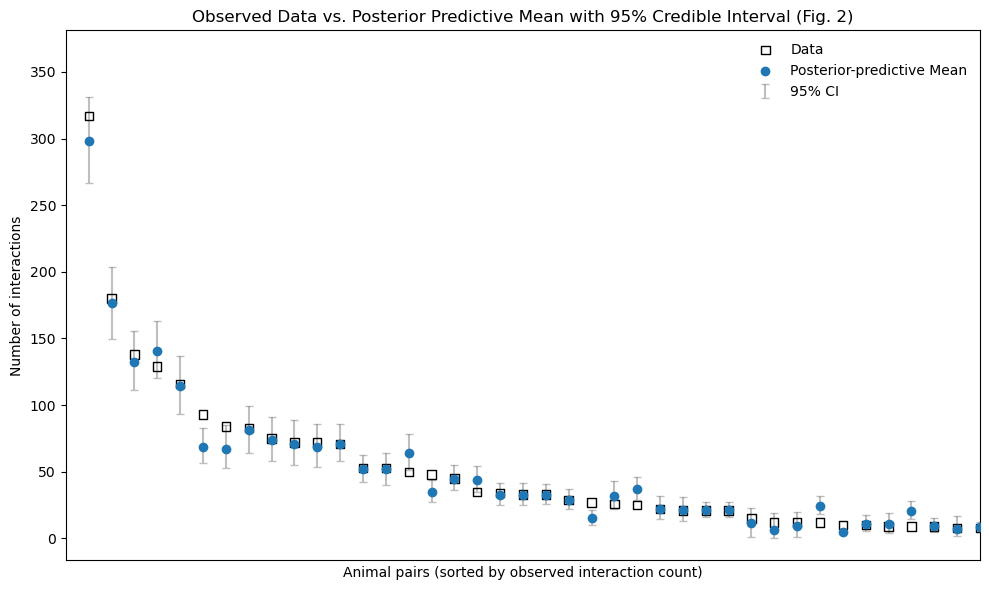

In [ ]:
plt.figure(figsize=(10, 6))
sort_order = np.argsort(-M.flatten())

M_flat_sorted = M.flatten()[sort_order]
M_tilde_mean_flat_sorted = M_tilde.flatten()[sort_order]
lower_bounds_flat_sorted = lower_bound_matrix.flatten()[sort_order]
upper_bounds_flat_sorted = upper_bound_matrix.flatten()[sort_order]

lower_errors = M_tilde_mean_flat_sorted - lower_bounds_flat_sorted
upper_errors = upper_bounds_flat_sorted - M_tilde_mean_flat_sorted
yerr_values = [lower_errors, upper_errors]

x_values = range(1, len(sort_order) + 1)


plt.scatter(x_values, M_flat_sorted, marker='s', facecolors='none', edgecolors='k', label='Data', zorder=5)
plt.scatter(x_values, M_tilde_mean_flat_sorted, label='Posterior-predictive Mean', zorder=10)

plt.errorbar(x_values, M_tilde_mean_flat_sorted, yerr=yerr_values, fmt='none',
             capsize=3, color='gray', alpha=0.5, label='95% CI', zorder=0)


plt.xlim(0,40)

plt.xticks([])

plt.xlabel('Animal pairs (sorted by observed interaction count)')
plt.ylabel(r'Number of interactions')

min_y = min(M_flat_sorted.min(), lower_bounds_flat_sorted.min())
max_y = max(M_flat_sorted.max(), upper_bounds_flat_sorted.max())

plt.ylim(min_y - abs(min_y)*0.1 - (max_y - min_y)*0.05, max_y + abs(max_y)*0.1 + (max_y - min_y)*0.05)
plt.legend(frameon=False, markerfirst=True, loc='upper right')

plt.title('Observed Data vs. Posterior Predictive Mean with 95% Credible Interval (Fig. 2)')
plt.tight_layout()
plt.show()

### Posterior Predictive Fit: Quantitative Check

So far, visual inspections (e.g., matrix heatmaps, credible intervals) suggest that the model reproduces the observed interaction patterns quite well.

To complement those qualitative assessments, we now perform a quantitative goodness-of-fit test using a discrepancy measure.

---

### Chi-Square Discrepancy Test

We calculate the following test statistic:

```python
X_2 = np.sum((M - M_tilde)**2 / M_tilde)
```

This is a form of the posterior predictive discrepancy or chi-square-like statistic, which measures the total deviation between the observed data matrix `M` and the model's predicted matrix `M_tilde`. Lower values indicate better fit.

Next, we compare this value to a reference distribution.

### Interpretation

- **Calculated discrepancy**:  
  $X^2 = 262.85$

- **Expected discrepancy under the null (random model)**:  
  $\mathbb{E}[X^2] \approx 16{,}383.52$

- **95% lower threshold from null model**:  
  $X^2_{5\%} \approx 16{,}088.18$

Since our calculated $X^2$ is dramatically lower than the 5th percentile of the null distribution, we can confidently say:

> The model fits the data significantly better than what would be expected under a random or misspecified model.  
>  
> With 95% confidence or more, we reject the null hypothesis that the fit is no better than random.

This confirms — both visually and statistically — that our Bayesian model effectively captures the structure of the trophic interaction network in the `FOODWEB-BAYDRY` system.

In [ ]:
X_2=np.sum((M-M_tilde)**2/M_tilde)
print(f"\nCalculated Discrepancy (X^2): {round(X_2,2)}")
from scipy.stats import chi2
num_simulations=10000
degrees_of_freedom = n_p * n_a

  # Generate random samples from the chi-square distribution
chi_samples = chi2.rvs(df=degrees_of_freedom, size=num_simulations)

  # Estimate the expected value as the mean of the samples
estimated_expected_value = np.mean(chi_samples)

print(f"\nIf Estimated Discrepancy (X^2) is lower than: {round(np.percentile(chi_samples,5),2)}")
print(", we can affirm with 95% confidence or more that our model is better than a random/obsolete model")
print(f"\nExpected Discrepancy (X^2): {round(estimated_expected_value,2)}")


Calculated Discrepancy (X^2): 262.85

If Estimated Discrepancy (X^2) is lower than: 16088.18
, we can affirm with 95% confidence or more that our model is better than a random/obsolete model

Expected Discrepancy (X^2): 16383.52


### Fig. 1(c) — Inferred Network Structure and Abundances

This figure presents a composite view of the inferred trophic network structure and the posterior estimates of relative abundance for each species.

- The **central heatmap** displays the estimated edge probability matrix $Q$, where $Q_{ij}$ is the probability that species $j$ consumes species $i$.
- The **top histogram** shows the posterior mean abundances $\tau_j$ of consumer taxa (i.e., those that consume others).
- The **right histogram** shows the posterior mean abundances $\sigma_i$ of resource taxa (i.e., those that are consumed).

These marginal distributions correspond to the simplex parameters $\tau$ and $\sigma$ learned by the model. These reflect relative "ecological activity" — how much a species is estimated to participate in the network, in terms of being a resource or consumer.

#### Interpretation:

- Species with high abundance values (peaks in histograms) contribute strongly to the observed network structure.
- Dense blocks in the heatmap indicate generalist consumers or widely available resources.
- The overall sparsity reflects the ecosystem's trophic specialization and confirms that most potential interactions are absent or weakly supported by the data.

This visualization complements the matrix-based fit diagnostics by offering a structural perspective on species roles and interaction likelihoods.

In [ ]:
edge_prob = pp.estimate_network(samples)

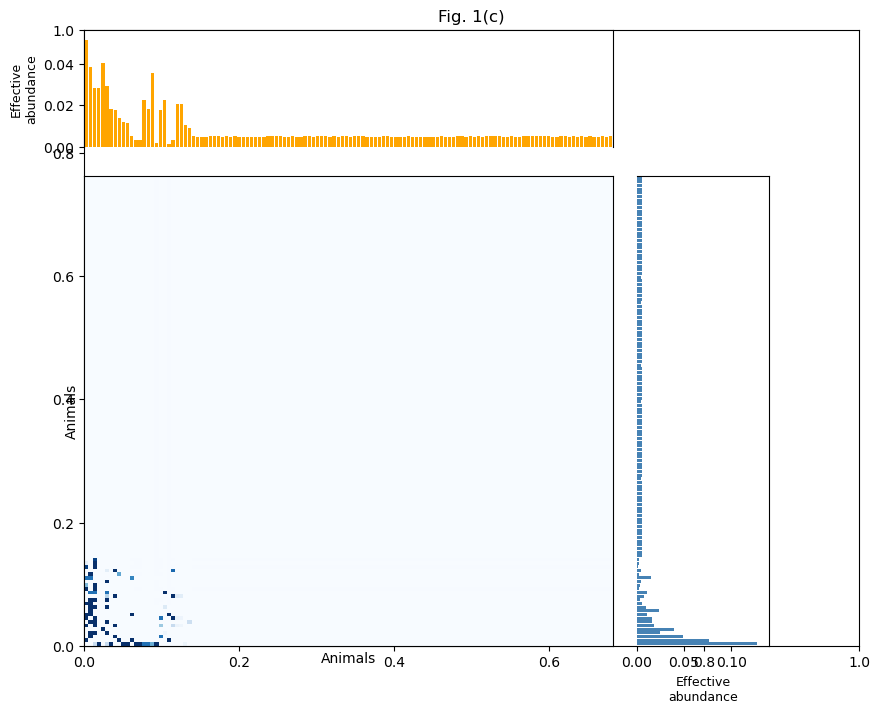

In [ ]:
pp.figure_1_c(samples,n_a,n_p)

### Subset Analysis of Interaction Probabilities

To further inspect model predictions, we visualize a 30 × 30 subset of the interaction matrix and its posterior estimates. This helps us examine the fine-scale structure of specific taxa pairs.

We use the command below to generate the plots.

This generates three panels:

1. **Input matrix (Subset)**
   This heatmap shows the empirical interaction counts for a selected subset of species pairs. As expected for sparse ecological networks, most interactions are concentrated in a few cells, while the majority are zero.

2. **Posterior edge probability (Subset)**
   This panel displays the inferred probability of interaction $Q_{ij}$ for the same subset, based on posterior samples. High-probability links (closer to 1) appear in dark blue, confirming strong model certainty in a few key interactions.

3. **Posterior-predictive mean (Subset)**
   Here we visualize the posterior-predictive mean number of interactions $\mathbb{E}[\tilde{M}_{ij}]$, which accounts for both the estimated interaction strength and uncertainty. The structure generally mirrors the observed matrix but with smoother gradients due to Bayesian averaging.

### Subset Interaction Diagnostics

This focused subset view allows us to:

- Identify high-confidence interactions and highlight which species pairs are consistently predicted to interact.
- Spot discrepancies between observed and predicted interaction structure.
- Evaluate uncertainty in predictions, which is useful for prioritizing future empirical sampling.
- Infer ecological roles, such as:
  - **Generalists**: species that interact with many partners.
  - **Specialists**: species that interact with few, but more strongly.

This localized diagnostic is particularly valuable for evaluating how well the model captures fine-scale trophic structure, which may be obscured in aggregate metrics.

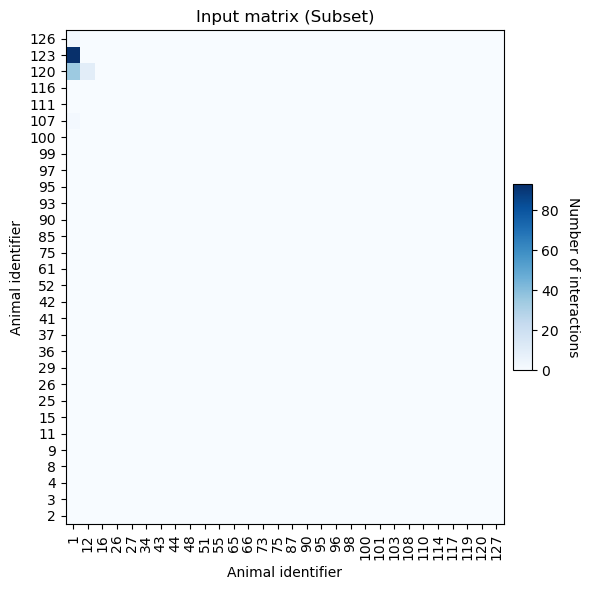

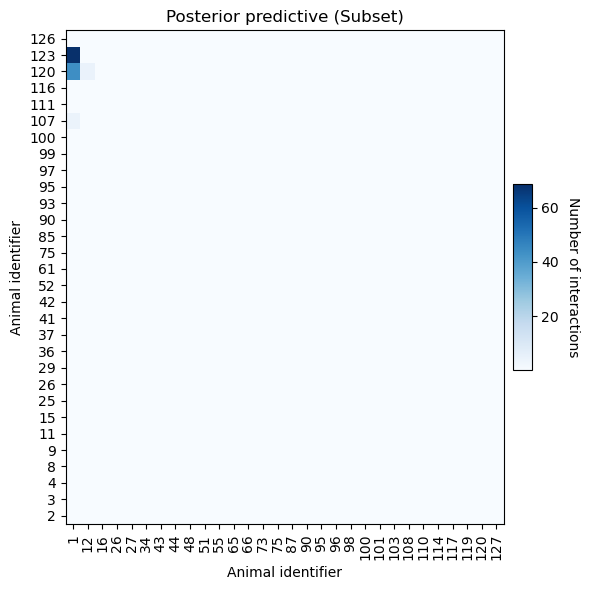

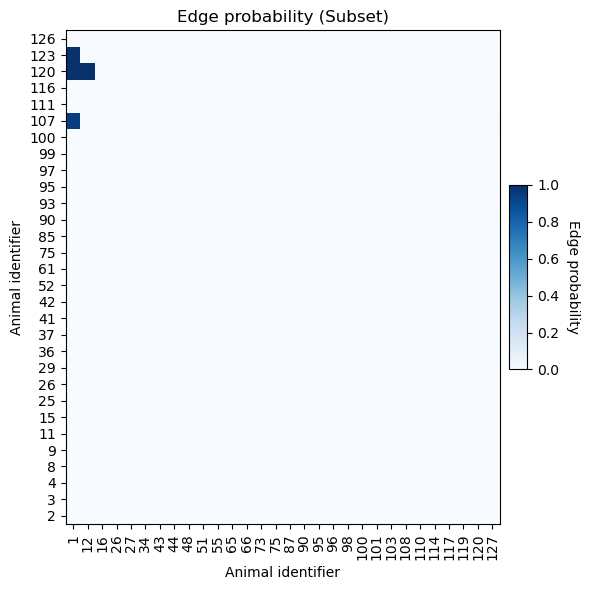

In [ ]:
# Define the desired subset size
subset_animals = 30


# Call the plotting function
pp.plot_subset_interaction_matrices(
    M,
    M_tilde,
    edge_prob,
    n_p,
    n_a,
    subset_animals,
    subset_animals
)

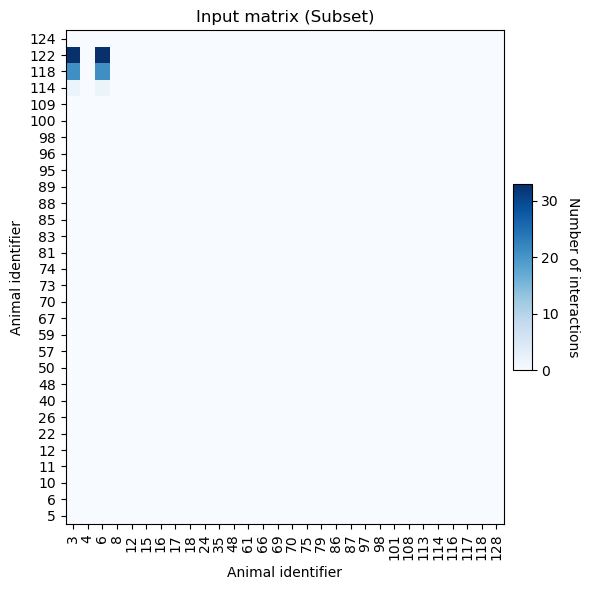

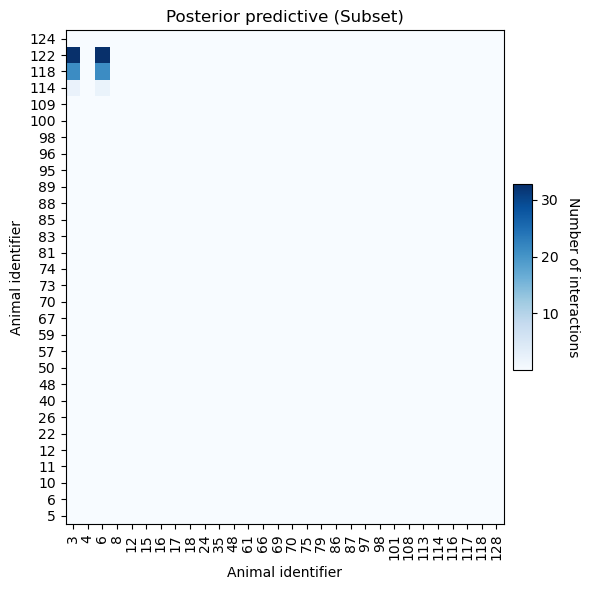

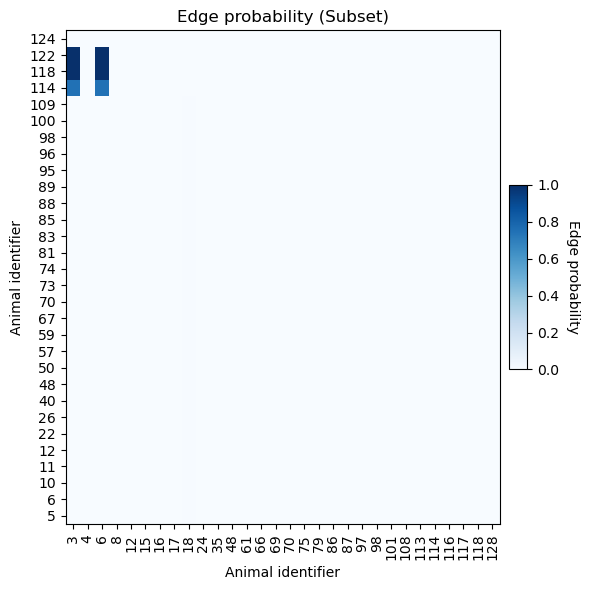

In [ ]:
# Define the desired subset size
subset_animals = 30


# Call the plotting function
pp.plot_subset_interaction_matrices(
    M,
    M_tilde,
    edge_prob,
    n_p,
    n_a,
    subset_animals,
    subset_animals
)

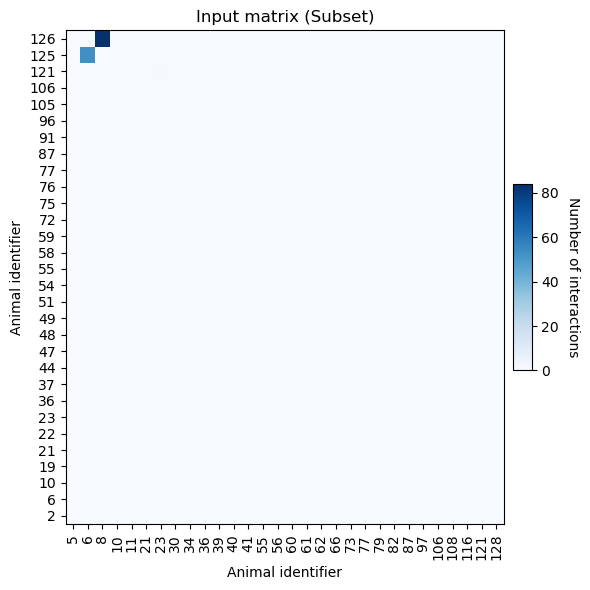

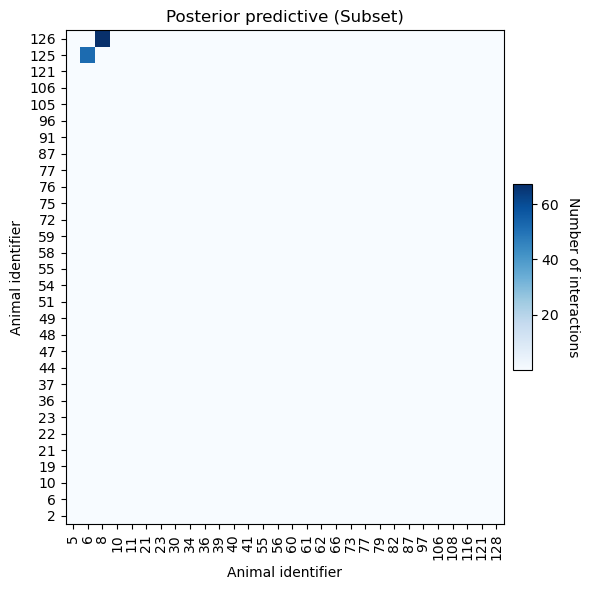

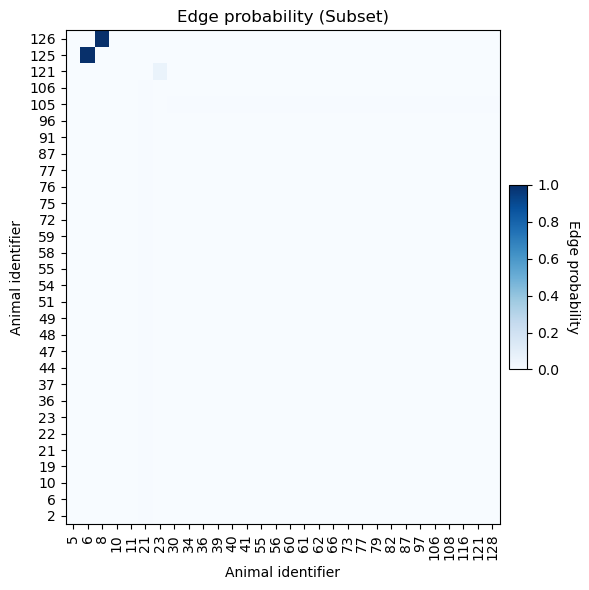

In [ ]:
# Define the desired subset size
subset_animals = 30


# Call the plotting function
pp.plot_subset_interaction_matrices(
    M,
    M_tilde,
    edge_prob,
    n_p,
    n_a,
    subset_animals,
    subset_animals
)

### Estimated Network Connectance

We now extract the posterior mean of the connectance parameter $\rho$:

- $\rho$ represents the prior probability of interaction between any two taxa.
- It reflects the overall sparsity of the inferred trophic network.

The posterior mean of $\rho$ is:

$$
\hat{\rho} = 0.0069
$$

This value confirms that the interaction network is extremely sparse — only about 0.69% of possible species pairs are expected to interact.

Such low connectance is typical of ecological food webs, especially in systems where specialization or trophic constraints limit feasible interactions.

In [ ]:
round(samples['rho'].mean(),4)

np.float64(0.0069)

### Posterior Distribution of Connectance $\rho$

The histogram below (Fig. 3(a)) shows the full posterior distribution of the connectance parameter $\rho$ across all samples:

- The distribution is tightly concentrated between 0.004 and 0.010, with a peak near the posterior mean.
- This reinforces the conclusion that the model infers a very sparse interaction structure, in line with ecological expectations.

Visualizing the full posterior allows us to assess uncertainty and variability around $\rho$, providing a more complete view than the point estimate alone.

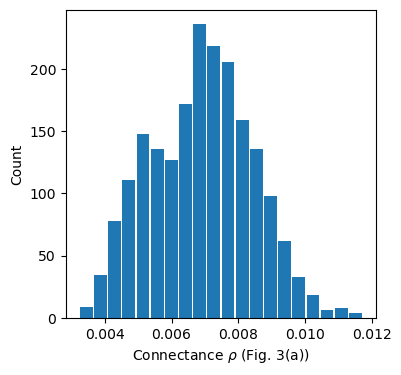

In [ ]:
plt.figure(figsize=(4,4))
plt.hist(samples['rho'], density=False, bins=20, rwidth=0.9);

plt.xlabel(r'Connectance $\rho$ (Fig. 3(a))')
plt.ylabel('Count')
plt.show()

### Posterior Distribution of Preference Parameter $r$

The histogram in Fig. 3(b) displays the posterior distribution of the interaction preference parameter $r$:

- The majority of posterior samples are clustered near low values, with a sharp spike near zero.
- A long right-skewed tail extends toward high values (up to over 60,000), indicating substantial uncertainty.

This behavior is expected:

- $r$ controls how much more likely interactions are when they exist (i.e., $B_{ij} = 1$) versus when they do not.
- Large values of $r$ imply strong discrimination between realized and unrealized links.
- However, in sparse networks like food webs, where many interactions are absent, the data may not strongly constrain $r$, leading to a diffuse tail.

The plot underscores that while the model often favors high interaction contrast, the precise magnitude is uncertain.

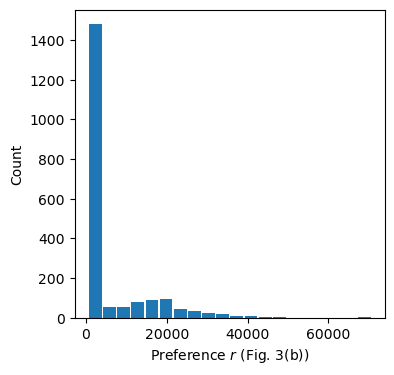

In [ ]:
plt.figure(figsize=(4,4))
plt.hist(samples['r'], density=False, bins=20, rwidth=0.9);

plt.xlabel(r'Preference $r$ (Fig. 3(b))')
plt.ylabel('Count')
plt.show()

### Posterior Distribution of Network Nestedness (NODF)

To assess higher-order structure in the inferred networks, we calculate the nestedness of posterior network samples using the NODF metric:

- We draw multiple binary interaction matrices from the posterior edge probability matrices $Q$ by thresholding with Bernoulli draws.
- For each sampled matrix, we compute the NODF score, a standard measure of nestedness in ecological networks.

The histogram below shows the distribution of NODF scores across these posterior samples (Fig. 3(c)):

- Nestedness captures the extent to which interactions of specialist taxa are subsets of those of generalists.
- A higher NODF indicates more hierarchical structure in the network.

This posterior distribution provides insight into the structural organization of the inferred trophic web and enables uncertainty quantification in nestedness-related analyses.

The posterior mean nestedness across all sampled networks is:

$$
\mathbb{E}[\text{NODF}] = 0.0973
$$

This low value is consistent with the sparse and possibly compartmentalized nature of trophic networks like the Florida dry-season food web. It also reflects the model’s preference for structures with minimal redundancy, as predicted under low connectance and strong specialization.

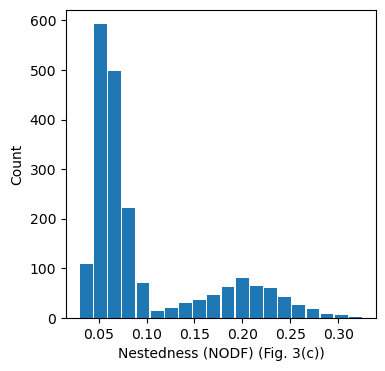

In [ ]:
from scipy.stats import bernoulli
edge_probability_matrices=pp.estimate_networks(samples)

for i in range(edge_probability_matrices.shape[0]):
    edge_probability_matrices[i,:,:]=bernoulli.rvs(edge_probability_matrices[i,:,:])

nodf_values=np.zeros(edge_probability_matrices.shape[0])

for i in range(edge_probability_matrices.shape[0]):
    nodf_values[i] = pp.compute_nodf(edge_probability_matrices[i,:,:])

plt.figure(figsize=(4,4))
plt.hist(nodf_values, density=False, bins=20, rwidth=0.9);

plt.xlabel("Nestedness (NODF) (Fig. 3(c))")
plt.ylabel('Count')
plt.show()

In [ ]:

print(np.mean(nodf_values))

0.09727203693897281


### Edge Probability Variability Across Posterior Samples

The heatmap below visualizes the standard deviation of edge probabilities across posterior samples:

- For each species pair $(i, j)$, we compute the standard deviation of their posterior edge probabilities $Q_{ij}^{(s)}$ across all samples.
- Brighter (darker blue) colors indicate greater uncertainty in the presence of an interaction.
- White or light-colored cells represent edges with low posterior variability — either consistently present or consistently absent.

#### Why This Matters

- This diagnostic helps identify unstable links in the inferred network — species pairs with ambiguous interaction support.
- High variability suggests that additional data or expert knowledge may be needed to confirm such links.
- Conversely, consistently predicted interactions (low variability) are strong candidates for robust ecological relationships.

This kind of uncertainty heatmap is particularly useful for guiding targeted empirical validation or experimental sampling in future ecological surveys.

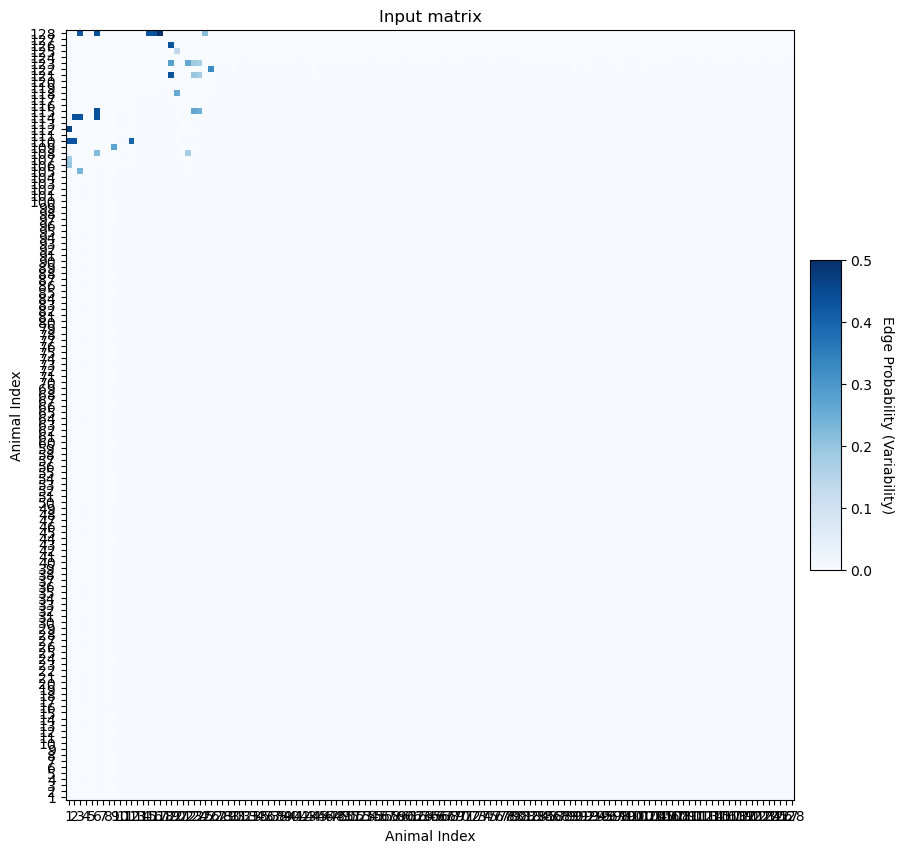

In [ ]:
edge_probability_matrices=pp.estimate_networks(samples)

plt.figure(figsize=(10,10))
plt.title('Input matrix')
plt.pcolormesh(edge_probability_matrices.std(axis=0), cmap=plt.cm.Blues)
cb= plt.colorbar(fraction=0.04, pad=0.02, aspect=10)
cb.ax.get_yaxis().labelpad = 15
cb.set_label('Edge Probability (Variability)', rotation=270)
plt.yticks(np.array(range(n_p)) + 0.5, range(1, n_p + 1))
plt.xticks(np.array(range(n_a)) + 0.5, range(1, n_a + 1))
plt.xlabel('Animal Index')
plt.ylabel('Animal Index')
plt.show()

### Posterior Predictive Variability in Interaction Counts

The heatmap above shows the standard deviation of predicted interaction counts $\tilde{M}_{ij}$ across all posterior samples:

- Each cell $(i, j)$ reflects how much the model’s prediction for that species pair varied across posterior draws.
- Darker shades indicate higher uncertainty in the predicted interaction strength between the corresponding taxa.

#### Interpretation

- Species pairs with low standard deviation were consistently predicted to have a similar number of interactions.
- High-variability cells highlight uncertain predictions, which may warrant closer examination or targeted data collection.
- This visualization complements the edge probability variability plot by focusing on interaction intensity rather than just binary presence/absence.

Such diagnostics are valuable when prioritizing validation experiments or interpreting the robustness of inferred ecological relationships.


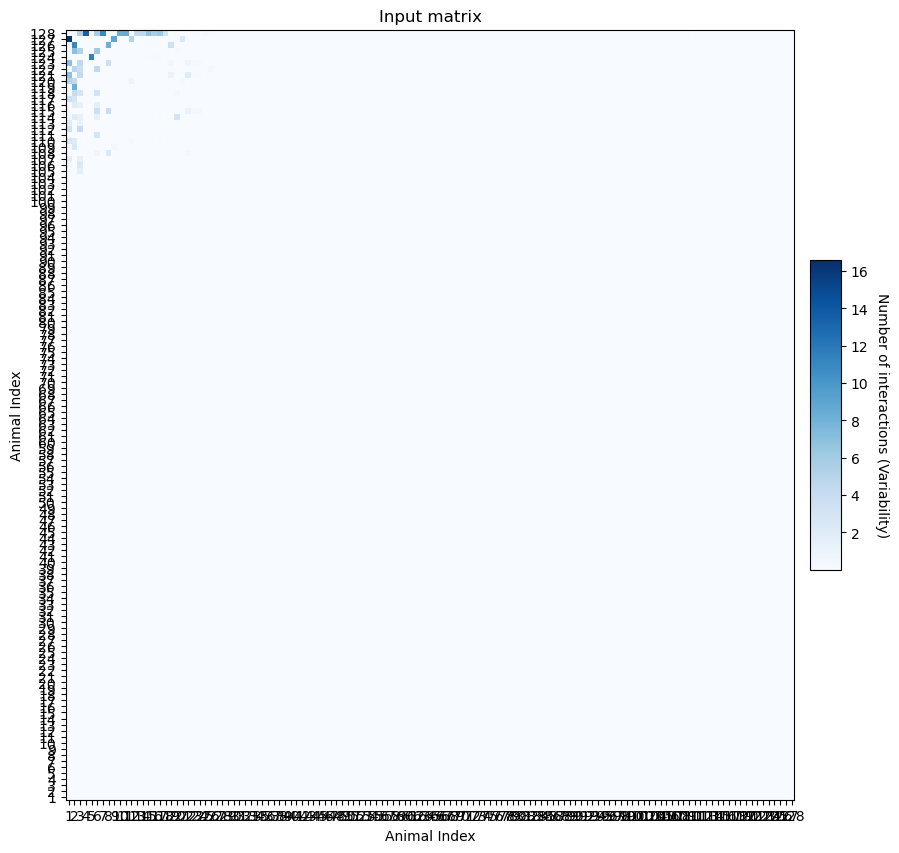

In [ ]:
plt.figure(figsize=(10,10))
plt.title('Input matrix')
plt.pcolormesh(posterior_samples.std(axis=0), cmap=plt.cm.Blues)
cb= plt.colorbar(fraction=0.04, pad=0.02, aspect=10)
cb.ax.get_yaxis().labelpad = 15
cb.set_label('Number of interactions (Variability)', rotation=270)
plt.yticks(np.array(range(n_p)) + 0.5, range(1, n_p + 1))
plt.xticks(np.array(range(n_a)) + 0.5, range(1, n_a + 1))
plt.xlabel('Animal Index')
plt.ylabel('Animal Index')
plt.show()

### Observed Visits vs. Inferred Abundances (Fig. 3(d))

This scatter plot compares:

- The total number of observed visits for each animal (summed across all interaction partners in matrix $M$),
- Against the corresponding posterior mean of $\sigma_i$, representing the inferred relative abundance of that species in the model.

#### Interpretation

- A clear positive association appears: animals with more observed interactions tend to have higher inferred abundance.
- This validates the model’s ability to incorporate empirical frequencies while regularizing estimates via the hierarchical prior.
- Note that some taxa with very low observed counts still receive non-zero abundance estimates, indicating the model’s partial pooling mechanism.

This relationship supports the model’s ecological realism and helps interpret $\sigma$ values in terms of observed sampling intensity.


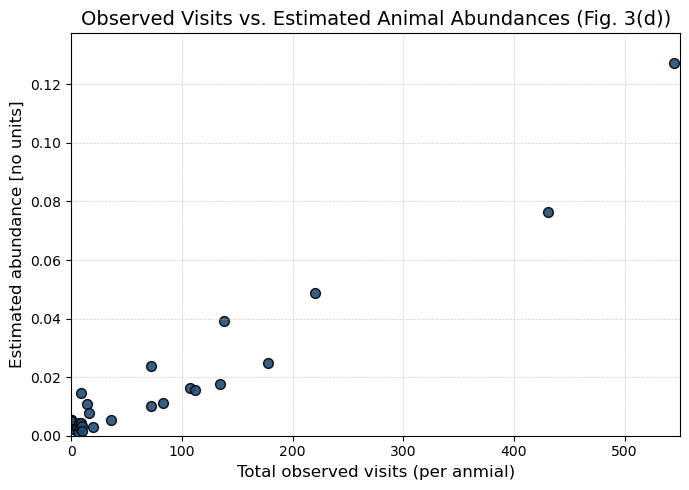

In [ ]:
# Compute observed total visits per animal (row sums of the M matrix)
observed_visits = M.sum(axis=1)  # M is the observed animal–animal interaction matrix

# Compute posterior mean of sigma for each animal
sigma_mean = samples['sigma'].mean(axis=0)

# Plotting
fig, ax = plt.subplots(figsize=(7, 5))

ax.scatter(
    observed_visits,
    sigma_mean,
    s=50,
    color="#1f4e79",
    edgecolor="black",
    alpha=0.9
)

# Axis labeling and formatting
ax.set_title("Observed Visits vs. Estimated Animal Abundances (Fig. 3(d))", fontsize=14)
ax.set_xlabel("Total observed visits (per anmial)", fontsize=12)
ax.set_ylabel("Estimated abundance [no units]", fontsize=12)
ax.set_xlim(0, observed_visits.max() + 5)
ax.set_ylim(0, max(sigma_mean) + 0.01)
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
ax.tick_params(axis='both', labelsize=10)

plt.tight_layout()
plt.show()

### Effect of Sampling Effort on Edge Probability Estimates (Fig. 4)

The plots below illustrate how data availability affects the posterior edge probability distribution inferred by the model.

We compare two scenarios:

#### **(a) Simulated Low-Data Condition**

- Constructed by randomly subsampling 50% of the species from the original dataset.
- The posterior edge probability matrix $\mathbf{Q}_{\text{sub}}$ was recalculated using the subset of $\sigma$ values.
- The histogram shows that most edge probabilities are concentrated near zero.
- This reflects high uncertainty and a conservative inference under sparse data conditions.

#### **(b) Aggregated (Full) Dataset**

- Uses the full observation matrix $M$ with all taxa included.
- The histogram of $\mathbf{Q}_{\text{full}}$ is similarly skewed, but shows a broader tail, indicating increased confidence in a small number of likely interactions.
- The model is able to sharpen its edge predictions when more interaction data are available.

---

These figures demonstrate the regularizing power of the Bayesian model:

- Under low data, the model defaults to low connectance, avoiding overfitting.
- With richer data, the model identifies and confirms stronger edges, while still maintaining sparsity.

This is crucial in ecological inference, where empirical sampling is often limited, and model robustness under uncertainty is essential.


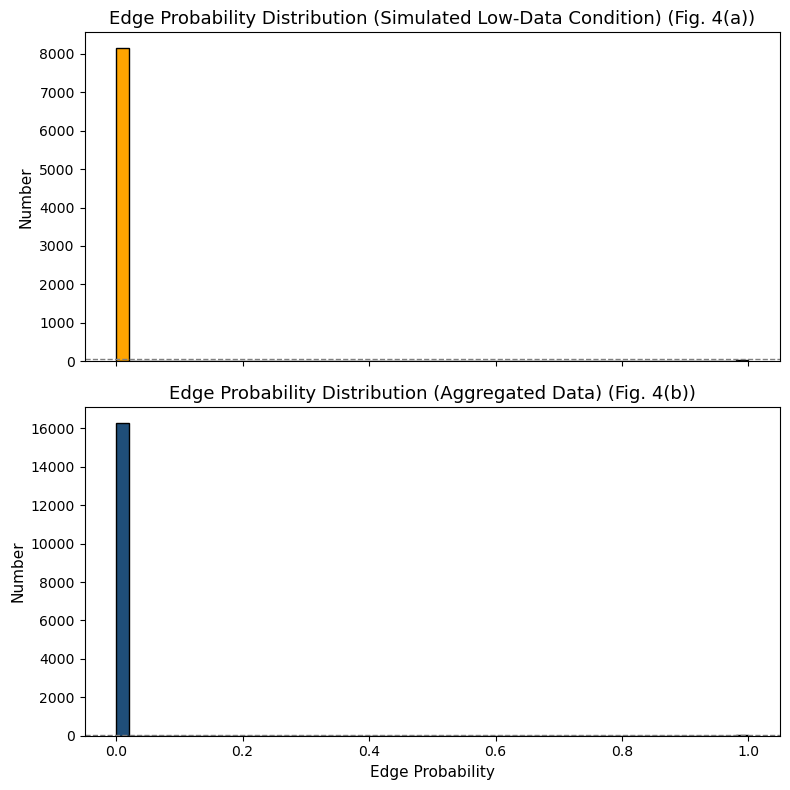

In [ ]:
# Simulate a low-data condition by subsampling rows
M_sub, sub_idx = pp.subsample_matrix(M, frac=0.5)
sigma_samples_sub = [sigma[sub_idx] for sigma in samples['sigma']]

# Compute posterior edge probabilities
Q_sub = pp.average_edge_probs(M_sub, samples['C'], samples['r'], samples['rho'], sigma_samples_sub, samples['tau'])
Q_full = pp.average_edge_probs(M, samples['C'], samples['r'], samples['rho'], samples['sigma'], samples['tau'])

# Flatten for plotting
qvals_sub = Q_sub.flatten()
qvals_full = Q_full.flatten()

# Plot histograms
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

# Figure 4a – subsampled (orange bars)
ax1.hist(qvals_sub, bins=50, color="orange", edgecolor='black')
ax1.axhline(50, color='gray', linestyle='--', linewidth=1)
ax1.set_title("Edge Probability Distribution (Simulated Low-Data Condition) (Fig. 4(a))", fontsize=13)
ax1.set_ylabel("Number", fontsize=11)

# Figure 4b – full data (blue bars)
ax2.hist(qvals_full, bins=50, color="#1f4e79", edgecolor='black')
ax2.axhline(50, color='gray', linestyle='--', linewidth=1)
ax2.set_title("Edge Probability Distribution (Aggregated Data) (Fig. 4(b))", fontsize=13)
ax2.set_xlabel("Edge Probability", fontsize=11)
ax2.set_ylabel("Number", fontsize=11)

plt.tight_layout()
plt.show()